# A simple and flexible model for record matching

#### Libraries needed

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import make_union, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier as Classifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans as Cluster
plt.style.use('fivethirtyeight')

from wookie.lrdftransformers import VectorizerConnector, ExactConnector, FuzzyConnector, VisualHelper
from wookie.preutils import createmultiindex, scores
from wookie.lrdftransformers.cluster import LrClusterQuestions, ClusterClassifier
from wookie.pipeline import PipeSbsClf, PruningLrSbsClf, PipeLrClf
from wookie.sbsdftransformers import FuncSbsComparator

#### Load the data

In [2]:
n_lines = 500
filepath_left = '/Users/paulogier/81-GithubPackages/wookie/operations/data/left.csv'
filepath_right = '/Users/paulogier/81-GithubPackages/wookie/operations/data/right.csv'
filepath_training = '/Users/paulogier/81-GithubPackages/wookie/operations/data/trainingdata.csv'
left = pd.read_csv(filepath_left, index_col=0, nrows=n_lines, dtype=str)
right = pd.read_csv(filepath_right, index_col=0, nrows=n_lines, dtype=str)
y_true = pd.read_csv(filepath_training, usecols=['ix_left', 'ix_right', 'y_true']).set_index(['ix_left', 'ix_right'])['y_true']
df_X = [left, right]
y_true = y_true.loc[
    y_true.index.intersection(createmultiindex(X=df_X))
]
n_possible_pairs= left.shape[0]*right.shape[0]
print('Two datasets of size {} and {}  rows yield:\n {} possible pairs to scan --> manually exhausting'.format(left.shape[0], right.shape[0], n_possible_pairs))
left.sample(5)

Two datasets of size 500 and 500  rows yield:
 250000 possible pairs to scan --> manually exhausting


,name,street,city,postalcode,duns,countrycode
ix,,,,,,
7d5c9986-013b-4b5b-b5ec-3c657558a680,lambda gmbhco kg,12 am bahnhof,bischofswiesen,83483,551265957.0,DE
62cb855d-9311-4482-a758-0918dd77edad,siemens ag,98 frauenauracher str,erlangen,91056,331535687.0,DE
9f0dae5b-ee0c-453c-b6b5-8506b23b6554,specialty fasteners components,unit d seymour wharf,totnes,tq9,233148675.0,GB
78b4a267-3adf-46a8-afc9-35d8f07e5b14,buerklin ohg,80 am wehrhahn,dusseldorf,40211,316757657.0,DE
f8c181dc-bac8-401d-9c7f-08d5caf5cfc8,trescal limited,park gate close,stockport,sk6 2sl,215592268.0,GB


# How similar are the records with one another?

#### The framework is fully compatible with open-source Scikit-Learn Machine Learning libraries

In [3]:
scorer = make_union(*[
    VectorizerConnector(on='name', analyzer='word', ngram_range=(1,2)),
     VectorizerConnector(on='name', analyzer='char', ngram_range=(1,2)),
    VectorizerConnector(on='street', analyzer='word', ngram_range=(1,2)),
    VectorizerConnector(on='city', analyzer='char', ngram_range=(1,2)),
    ExactConnector(on='duns'),
    ExactConnector(on='countrycode')
])
imp = SimpleImputer(strategy='constant', fill_value=0)

pca = PCA(n_components=2)
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
t2d = make_pipeline(*[scorer, imp, pca, scaler])

X_score2d = t2d.fit_transform(df_X)

#### Time needed to process the data

In [4]:
# %%timeit
# t2.fit_transform(df_X)

In [5]:
#print('{} pairs processed per second'.format(df_X[0].shape[0]*df_X[1].shape[0] / 8))

### Density plot: how similar are the matches on a 2-d space
Using a sample of maximum 500 lines out of all possible pairs as it is computation intensive

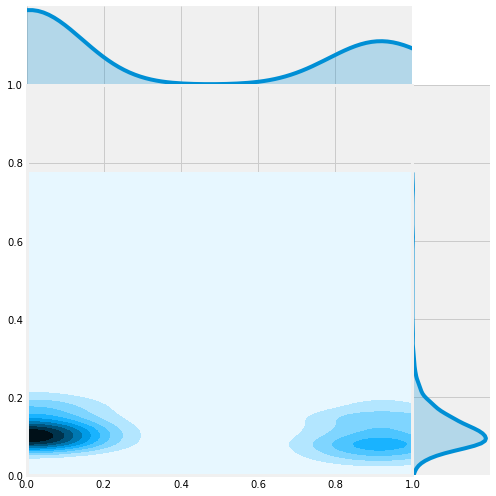

In [19]:
n_samples= np.random.choice(n_possible_pairs, min(500, n_possible_pairs))
X_sample2d = X_score2d[n_samples]
ax = sns.jointplot(X_sample2d[:,0], X_sample2d[:,1], kind="kde", height=7, space=0, xlim=(0,1.0), ylim=(0,1.0))

# Asking hard questions to train the model

### Cluster your data
Support all sklearn clusters

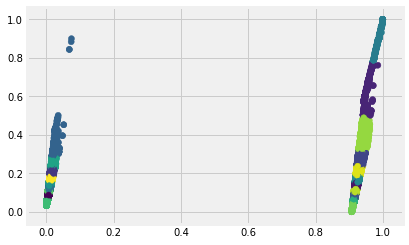

In [8]:
from wookie.lrdftransformers.cluster import LrClusterQuestions
cluster = Cluster(n_clusters=20)
explorer = LrClusterQuestions(transformer=t2d, cluster=cluster)
y_cluster = explorer.fit_predict(X=df_X)
plt.scatter(X_score2d[:, 0], X_score2d[:, 1], c=y_cluster);

### Ask representative questions

In [9]:
questions1 = explorer.representative_questions(X=df_X, n_questions=40)
questions1.sort_values(by='similarity').sample(5)

,,name_left,name_right,street_left,street_right,city_left,city_right,postalcode_left,postalcode_right,duns_left,duns_right,countrycode_left,countrycode_right,cluster,similarity
ix_left,ix_right,,,,,,,,,,,,,,
8af3a891-684c-46c9-9efc-77a0f3473f11,cbb76bc4-49fa-4bb7-bb3a-5fc37dbaca44,lapp systems gmbh,engelking elektronik gmbh,5 oskar lapp strae,16 albstr,stuttgart,tuningen,70565,78609,31792249.0,NaN,DE,DE,18,0.923700
ca12e2ba-9a2a-4a61-913c-f61ddd16952b,1d2b8332-9cfc-4c79-b27c-214c0e4c26b2,quality office supplier sl,quality office supplier sl,7 avenida de los pirineos,7 avenida de los pirineos,san sebastian de los reyes,san sebastin de los reyes,28703,28703,NaN,56524472.0,ES,ES,8,0.998322
eef729a2-3311-46d5-85b2-403e417981cf,d51ccd42-901f-4f8a-8a97-9dff7d458323,dichtelemente arcus gmbh,thales communications security,16 beckedorfer bogen,avenue de louvresses,seevetal,gennevilliers,21218,92622,313821894.0,772361978.0,DE,FR,11,0.020657
6694cef8-c256-4ead-bb58-b9e9a7bd15f1,8f54de0c-3eec-4e0d-9f39-29c9c6546f5e,roth gmbh und co kg,pitney bowes,28 zusamstr,7 tiergartenstr,augsburg,heppenheim,86165,64646,313234338.0,NaN,DE,DE,15,0.910602
65f1dcb1-357d-4ee2-8dbc-79b1bad4ce5c,8fcd15a7-046d-4080-8c4e-ef7a327f3096,srtechnics,selex es spa,calle de mario roso de luna,via dei castelli romani 2,madrid,pomezia,28022,00040,NaN,339891404.0,ES,IT,14,0.005476


In [10]:
answer1 = y_true
cluster_composition = explorer.cluster_composition(X=df_X, y=answer1, normalize='index')
cluster_composition

y_true,0,1
cluster,,
1,1.000000,0.000000
2,0.867133,0.132867
4,1.000000,0.000000
5,1.000000,0.000000
6,1.000000,0.000000
8,0.121076,0.878924
9,1.000000,0.000000
12,1.000000,0.000000
15,1.000000,0.000000


### Asking more pointed questions on mixed clusters

In [11]:
questions2 = explorer.pointed_questions(X=df_X, y=answer1,n_questions=10)
questions2.sort_values(by='similarity')

,,name_left,name_right,street_left,street_right,city_left,city_right,postalcode_left,postalcode_right,duns_left,duns_right,countrycode_left,countrycode_right,cluster,similarity
ix_left,ix_right,,,,,,,,,,,,,,
8183683d-b323-4739-ae25-bc8297b35cee,4423d322-4b71-4722-a668-aede6ea7cfce,hotel und gasthof bauer,dixi polytool gmbh,mnchner str,11 carl benz str,feldkirchen,birkenfeld,85622,55765,322170721.0,320051725.0,DE,DE,16,0.930799
d0c95a90-0ccf-4295-9a3d-27ab9e28f201,cd043bda-3f51-4f6f-86b1-eba782257f32,hotel und gasthof bauer,sommer gmbh cokg,mnchner str,rotwandweg,feldkirchen,taufkirchen,85622,82024,NaN,NaN,DE,DE,16,0.932301
aaa5650b-da51-497a-89e3-5e097a1bca00,cd63c740-214b-4a2f-9f9a-784f387e4054,gregor chemie gmbh,ykk deutschland gmbh,8 homburgstr,33 ostring,eschershausen,mainhausen,37632,63533,NaN,31692792.0,DE,DE,16,0.932989
6097f4c6-8515-41fb-b5e5-549c81140848,463f5bf5-f262-40fa-9706-c349c00bb5fe,bildungswerk der wirtschaft hamburg,zemo vertrieb gmbh i,10 kapstadtring,47 peutestr,hamburg,hamburg,22297,20539,NaN,NaN,DE,DE,2,0.949566
f704e1f0-b240-4461-a741-b41b5c30b476,463f5bf5-f262-40fa-9706-c349c00bb5fe,bildungswerk der wirtschaft hamburg,zemo vertrieb gmbh i,10 kapstadtring,47 peutestr,hamburg,hamburg,22297,20539,NaN,NaN,DE,DE,2,0.949566
009a86ad-346f-4e9a-bb43-57a1ed7bef26,572c004f-efb5-41b4-b5dc-737aabf9f79c,sogeti high tech toulouse,comptoir du sud ouest,3 chemin de laporte,boulevard de thibaud,toulouse,toulouse,31300,31084,261969181.0,NaN,FR,FR,2,0.952557
b3d57f9d-db16-42b5-ac05-44a27f15fc97,18d3383f-6dfa-4824-bbff-b24c316e7f93,aeroflex ltd,aeroflex test solutionsunits 14 15,monks brook industrial park,monks brook ind pk,chandler s ford,chandler s ford,so534ra,so534ra,NaN,NaN,GB,GB,2,0.961550
b1120134-9729-48c8-8e80-f6dd7e2a19a3,c0b48772-ae9c-483d-aff9-9874e3c00c5d,sogeti high tech,sogeti high tech sas,bp n 90076,2 av l escadrille normandie niemen,blagnac,blagnac,31700,31700,287711456.0,287711456.0,FR,FR,8,0.984118
253ce464-33bd-41cc-a078-81f262216c45,78ff3962-6e0f-40f3-8af8-3b3d5f38351c,hamilton sundstrand,hamilton sundstrand aerospace,4747 harrison ave,4747 harrison ave,rockford,rockford,61108-7929,61108-7929,51079937.0,149872194.0,US,US,8,0.990542


In [12]:
answer2 = y_true
cluster_composition = explorer.cluster_composition(X=df_X, y=y_true, normalize='index').sort_values(by=1, ascending=False)
cluster_composition

y_true,0,1
cluster,,
8,0.121076,0.878924
2,0.867133,0.132867
16,0.984127,0.015873
1,1.000000,0.000000
4,1.000000,0.000000
5,1.000000,0.000000
6,1.000000,0.000000
9,1.000000,0.000000
12,1.000000,0.000000


### Scatter plot using labelled data

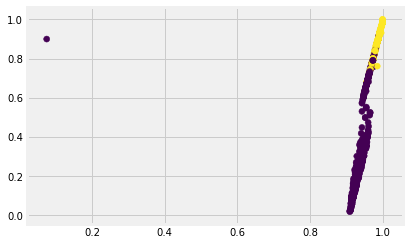

In [13]:
Xpd = pd.DataFrame(data=X_score2d, index=createmultiindex(df_X))
on_ix = y_true.index.intersection(Xpd.index)
plt.scatter(Xpd.loc[on_ix, 0], Xpd.loc[on_ix, 1], c=y_true.loc[on_ix]);

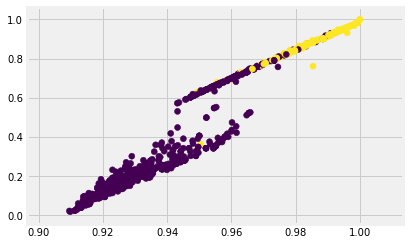

In [14]:
# we remove the outlier to zoom on the separation frontier
on_ix2 = on_ix.drop(Xpd.loc[on_ix, 0].idxmin())
plt.scatter(Xpd.loc[on_ix2, 0], Xpd.loc[on_ix2, 1], c=y_true.loc[on_ix2]);

# Make prediction using training data

### We use the cluster classifier to deal the data in 3 parts:
With the similarity matrix from the (left, right) comparators such defined, the clustering done, and the training data, we can thus categorize the clusters in three groups
- the clusters where there is no positive matches in the training data and where all the pairs are surely not a match (the vast majority of them)
- the clusters where there is only positive matches and where we are pretty confident that these are real matches
- the clusters where there is a mixed of positive and negative samples and where we need further comparators and more intelligent classifiers to take a decision

The ClusterClassifier, using the similarity matrix and the training data, gives the following predictions:
- 0 for sure non matches
- 1 for uncertain matches
- 2 for sure matches

### Repartition of the clusters in terms of proportion

In [31]:
clf1 = ClusterClassifier(cluster=cluster)
clf1.fit(X=Xpd.loc[on_ix], y=y_true)
y_pred_lr = pd.Series(clf1.predict(X=X_score2d), index= createmultiindex(df_X))
y_pred_lr.value_counts()/y_pred_lr.shape[0]

0    0.993720
1    0.005744
2    0.000536
dtype: float64

### We can pipeline the transformer Left Right and the classifier using a class called PipeLrClf

In [30]:
lrmodel = PipeLrClf(transformer=t2d, classifier=clf1)
# lr model has fit and predict capabilities

### Pruning the data
Concentrating on the 2% of mixed matches for further analysis and classifying 98% of the possible pairs is called pruning. It helps a lot reduce the number of comparisons done (in-depth comparison are much more memory-intense)

### Doing further analysis
We bring in new comparators, with compare the dataframe on a side-by-side basis. They use in particular the famous FuzzyWuzzy Library using the Levenshtein distance. Moreover, we can bring any classifier we want from scikit-learn supervised machine learning libraries. We Pipe SbsComparators and Classifier using a clas called PipeSbsClf

In [17]:
transformer2 = make_union(*[
    FuncSbsComparator(on='name', comparator='fuzzy'),
    FuncSbsComparator(on='name', comparator='token'),
    FuncSbsComparator(on='street', comparator='fuzzy'),
    FuncSbsComparator(on='city', comparator='fuzzy'),
    FuncSbsComparator(on='postalcode', comparator='fuzzy'),

])
imp2 = SimpleImputer(strategy='constant', fill_value=0)
pca3 = PCA(n_components=3)
transformer2 = make_pipeline(*[transformer2, imp2, pca3])
clf2 = Classifier()
sbsmodel = PipeSbsClf(transformer=transformer2, classifier=clf2)

### Pipelining the two steps above
This is done using a class Called aptly PruningLrSbsClf

In [18]:
pipe = PruningLrSbsClf(lrmodel=lrmodel, sbsmodel=sbsmodel)
pipe.fit(X=df_X, y_lr=y_true, y_sbs=y_true)
y_pred = pd.Series(
    data=pipe.predict(X=df_X),
    index=createmultiindex(X=df_X),
    name='y_pred'
)
y_pruning = pd.Series(data=np.where(y_pred_lr >1, 1, y_pred_lr), index= createmultiindex(X=df_X))
pruningscores = scores(y_true=y_true, y_pred=y_pruning)
finalscores = scores(y_true=y_true, y_pred=y_pred)
for c in pruningscores.keys():
    print('\n {}\n pruning:{}\nfinal{}\n'.format(c, pruningscores[c], finalscores[c]))


 precision
 pruning:0.5454545454545454
final1.0


 recall
 pruning:1.0
final0.9953703703703703


 f1
 pruning:0.7058823529411764
final0.9976798143851509


 accuracy
 pruning:0.7727272727272727
final0.9987373737373737


 balanced_accuracy
 pruning:0.84375
final0.9976851851851851



# Visualizing the possible matches
This is done via a class called VisualHelper. Useful to export to excel

In [43]:
viz = VisualHelper()
goodmatches= y_pred.loc[y_pred==1].index
sbs = viz.transform(X=df_X, on_ix=goodmatches, usecols=['name', 'street', 'city', 'postalcode', 'countrycode'])
sbs['confidence'] = y_pred_lr.loc[goodmatches]
sbs.reset_index(drop=False, inplace=True)

#### matches with very high confidence

In [44]:
sbs.loc[(sbs['confidence']==2) & (sbs['ix_left']!=sbs['ix_right'])].sample(5)

,ix_left,ix_right,name_left,name_right,street_left,street_right,city_left,city_right,postalcode_left,postalcode_right,countrycode_left,countrycode_right,confidence
141,5a985e0b-9ee7-44fe-9401-a60dbdd9a589,1da7f6bc-fe99-44be-945c-a58968d8c808,polytec pt gmbh,polytec pt gmbh,1 7 polytec platz,1 7 polytec platz,waldbronn,waldbronn,76337,76337,DE,DE,2
9,303a4b5d-b64c-4ec3-8026-61ddc082efa0,69e3533d-b706-4b98-8979-bceef511318c,muehlinghaus hildesheim,muehlinghaus hildesheim,klingelholl,klingelholl,wuppertal,wuppertal,42281,42281,DE,DE,2
171,a65009a4-dbbf-460f-8e22-ad8d00ea2ab7,b4f277e0-823f-416a-81e9-6fc17491f0dd,sna europe,sna europe,willettstr,willettstr,mettmann,mettmann,40822,40822,DE,DE,2
177,c9f2444f-8501-47b6-91a9-86bc9146e054,4c9d0555-39b9-4fb7-b181-25c84904ef67,natixis factor,natixis factor,10 12 avenue winston churchill,10 12 avenue winston churchill,charenton le pont,charenton le pont,94220,94220,FR,FR,2
176,c9f2444f-8501-47b6-91a9-86bc9146e054,741c6dc2-f923-4fe0-a5c5-cc4b531d73d5,natixis factor,natixis factor,10 12 avenue winston churchill,avenue winston churchill,charenton le pont,charenton le pont,94220,94220,FR,FR,2


#### probable matches

In [45]:
sbs.loc[(sbs['confidence']==1)].sample(5)

,ix_left,ix_right,name_left,name_right,street_left,street_right,city_left,city_right,postalcode_left,postalcode_right,countrycode_left,countrycode_right,confidence
51,0a8de44c-737e-4f10-bb2c-2ae14687aa62,3116e653-1354-4b8d-8811-f1a7e1bd9742,rdmadrid sl,rd madrid sl,79 calle de caleruega,79 calle de caleruega,madrid,madrid,28033,28033,ES,ES,1
130,7d694999-c376-448f-8ae4-a5870b75f96b,8e71eb0a-ca9f-4de1-917a-4108a8c56a6f,nespresso deutschland gmbh,nespresso deutschland gmbh b 746m6,8 zollhof,8 zollhof,dusseldorf,dusseldorf,40221,40221,DE,DE,1
331,28874a33-cb76-4a3d-8d25-4542c38f44cd,b24a5771-a49a-4cf3-9b71-5aea388b538b,zarm technik ag,zarm technik gmbh,am fallturm,am fallturm,bremen,bremen,28359,28359,DE,DE,1
15,6c39db4f-af5f-4073-a447-d42f79981ac1,4c9d0555-39b9-4fb7-b181-25c84904ef67,natixis factor,natixis factor,1012 avenue winston churchill,10 12 avenue winston churchill,charenton le pont,charenton le pont,94220,94220,FR,FR,1
136,85defdc1-6bb3-4beb-a458-4f5b43bbff74,08798f70-87df-48a5-9dee-6f0460e60429,hamilton sundstrand,hamilton sundstrand,4747 harrison ave,7002 po box,rockford,rockford,61108-7929,61124,US,US,1
